## Gas-Station protocol simulation
This Jupyter Notebook showcases an analysis of the Gas Station protocol and the financial risk to users under various market conditions

## 1. Initialization

### Import of the various libraries

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Simulation parameters

In [102]:
protocol_min_ratio = 1.5 # 400%
Number_of_users = 10000
rolling_window = 7

### Import the historical base fee data (source : https://etherscan.io/chart/gasprice)

In [103]:
historical_base_fee = (pd.read_csv("AvgGasPrice.csv",index_col="Date(UTC)")["Value (Wei)"]*(10**-9)).rolling(rolling_window).mean()
base_fee_extract = historical_base_fee[-366:]

### Protocol logic implementation

Each trove is defined by its collateral (in ETH), its debt (in gasETH), its initial collateralization ratio and an inattention parameter used to model a "top-up" behaviour

In [104]:
class trove :
    def __init__(self,_collateral,_debt,_initial_ratio,_inattention_parameter):
        self.collateral = _collateral
        self.debt = _debt 
        self.initial_ratio = _initial_ratio
        self.inattention_parameter = _inattention_parameter

    def collateral_ratio(self,base_fee):
        return self.collateral/(self.debt*(10**(-3))*base_fee)

Each modelled user can open a trove and top-up some collateral, we monitor the protocol risk using its total collateralization ratio (TCR)

In [105]:
class gasProtocol :

    def __init__(self,min_ratio):
        self.troves = {}
        self.min_ratio = min_ratio
        self.max_ID = 0
    
    def open_trove(self,_collateral,_debt,_initial_ratio,_inattention_parameter,base_fee):
        collateral_ratio = _collateral/(_debt*(10**(-3))*base_fee)

        if collateral_ratio < self.min_ratio :
            print("Collateral_ratio is too low")
        else :
            self.troves[self.max_ID] = trove(_collateral,_debt,_initial_ratio,_inattention_parameter)
            self.max_ID += 1

    def add_collateral(self,_amount,_trove_id):
        self.troves[_trove_id].collateral += _amount

    def check_for_liquidations(self,base_fee):
        troves_to_liquidate = []

        for key,trove in self.troves.items():
            if trove.collateral_ratio(base_fee) <= self.min_ratio :
                troves_to_liquidate.append(key)
        return troves_to_liquidate

    def total_collateral(self):
        total_collateral = 0
        for key,trove in self.troves.items() :
            total_collateral += trove.collateral
        return total_collateral

    def total_collateral_ratio(self,base_fee):
        total_collateral = 0
        total_debt = 0

        for key,trove in self.troves.items():
            total_collateral = total_collateral + trove.collateral
            total_debt = total_debt + trove.debt

        return total_collateral/(total_debt*(10**(-3))*base_fee)

## 2. Simulation

## Users initialization

### Initial base fee definition

In [106]:
initial_base_fee = base_fee_extract[0]

### Draw of users' parameters

In [107]:
Users_collateral = np.random.uniform(1,100,Number_of_users) # Distribution uniforme pour le collatéral
Users_ratio = np.random.exponential(0.5,Number_of_users) + 1.5*protocol_min_ratio
Users_debt = Users_collateral/(Users_ratio*(10**(-3))*initial_base_fee)
Users_inattention_parameter = np.random.gamma(25,0.02,Number_of_users)

### Plot of the various distributions

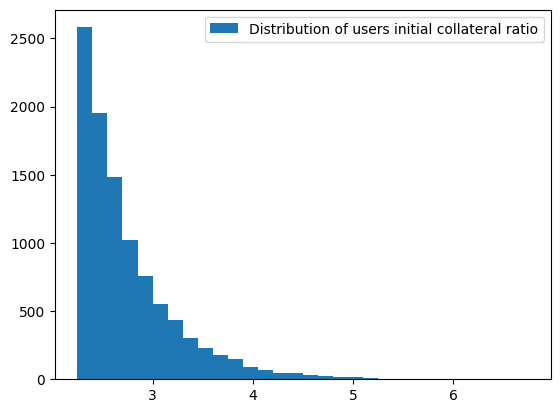

In [108]:
plt.hist(Users_ratio,label="Distribution of users initial collateral ratio",bins=30)
plt.legend()
plt.show()

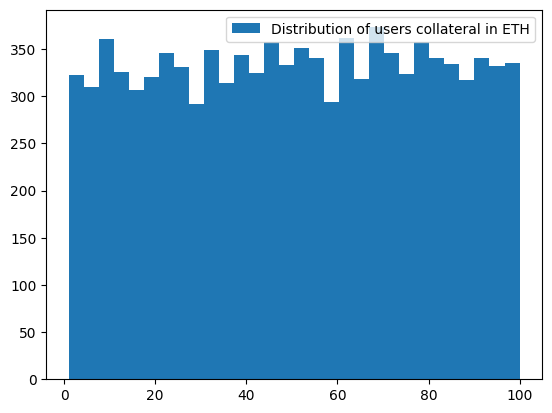

In [109]:
plt.hist(Users_collateral,label="Distribution of users collateral in ETH",bins=30)
plt.legend()
plt.show()

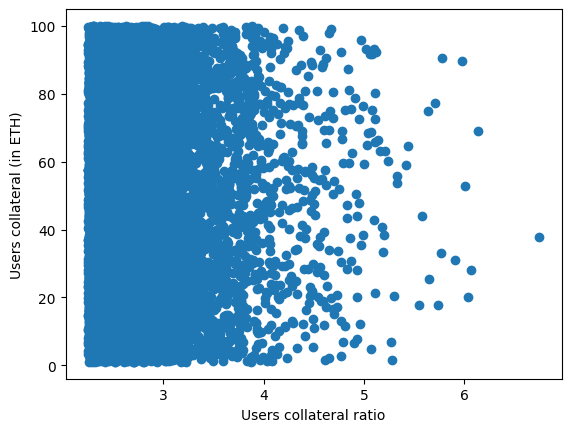

In [110]:
plt.scatter(Users_ratio,Users_collateral)
plt.xlabel("Users collateral ratio")
plt.ylabel("Users collateral (in ETH)")
plt.show()

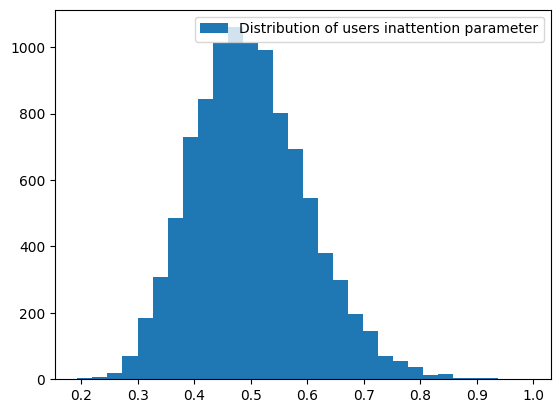

In [111]:
plt.hist(Users_inattention_parameter,label="Distribution of users inattention parameter",bins=30)
plt.legend()
plt.show()

## Simulation program

In [112]:
""" Simulation routine """

time_period = len(base_fee_extract) - 1
protocol_TCR = []
liquidation_count = []
total_collateral = []
protocol = gasProtocol(protocol_min_ratio)

""" Troves initiation """

for i in range(Number_of_users):
    protocol.open_trove(Users_collateral[i],Users_debt[i],Users_ratio[i],Users_inattention_parameter[i],initial_base_fee)

protocol_TCR.append(protocol.total_collateral_ratio(initial_base_fee))
""" Time period simulation """

for j in range(time_period):
    """ Update the base fee """
    base_fee = base_fee_extract[j+1]

    """ Check for liquidations """
    liquidable_troves = protocol.check_for_liquidations(base_fee)

    """ Top-ups """
    for key,trove in protocol.troves.items() :
        if (trove.collateral_ratio(base_fee)>= trove.initial_ratio - trove.inattention_parameter) or (trove.collateral_ratio(base_fee)<=trove.initial_ratio + trove.inattention_parameter) :
            pass
        else :
            amount = trove.initial_ratio*trove.debt*base_fee*(10**(-3)) - trove.collateral
            protocol.add_collateral(amount,key)
    
    protocol_TCR.append(protocol.total_collateral_ratio(base_fee))
    liquidation_count.append(len(liquidable_troves))
    total_collateral.append(protocol.total_collateral())


## Simulation results

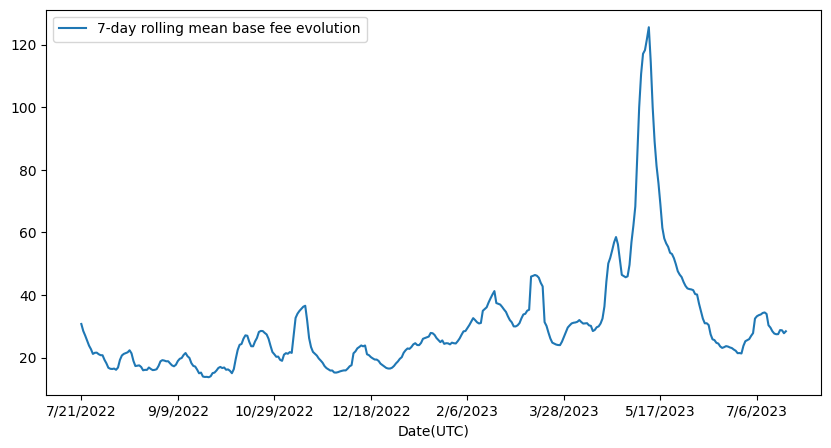

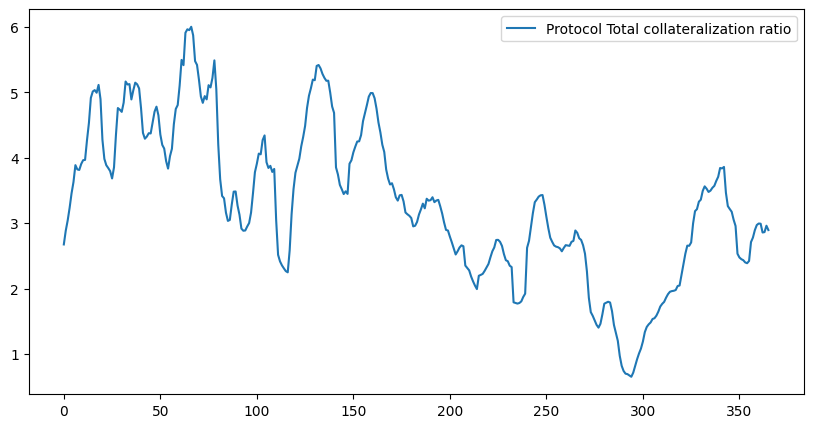

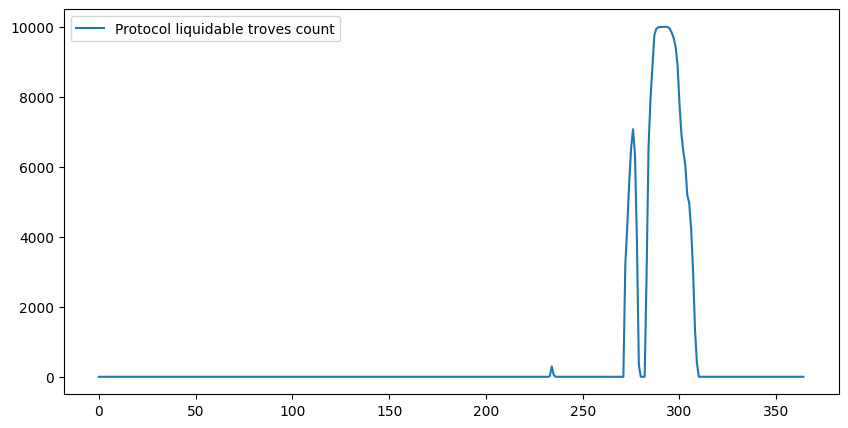

In [113]:
fig1 = plt.figure(1,figsize=(10,5))
base_fee_extract.plot(label= str(rolling_window) + "-day rolling mean base fee evolution")
plt.legend()
plt.show()
fig2 = plt.figure(2,figsize=(10,5))
plt.plot(protocol_TCR,label="Protocol Total collateralization ratio")
plt.legend()
plt.show()
fig3 = plt.figure(3,figsize=(10,5))
plt.plot(liquidation_count,label="Protocol liquidable troves count")
plt.legend()
plt.show()